In [1]:
import torch
import pandas as pd
path = "https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014837.csv.gz"
df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])

#https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014839.csv.gz

/tmp/ipykernel_273679/1724107054.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [4]:
df["element"].isin(["TMIN", "TMAX"])

0          True
1          True
2          True
3          True
4          True
          ...  
409846    False
409847    False
409848    False
409849    False
409850    False
Name: element, Length: 409851, dtype: bool

In [7]:
df2 = df[df["element"].isin(["TMIN", "TMAX"])]
df2.head()

,station,date,element,value,m,q,s,obs
0,USW00014837,19391001,TMAX,194,NaN,NaN,X,NaN
1,USW00014837,19391002,TMAX,211,NaN,NaN,X,NaN
2,USW00014837,19391003,TMAX,233,NaN,NaN,X,NaN
3,USW00014837,19391004,TMAX,272,NaN,NaN,X,NaN
4,USW00014837,19391005,TMAX,211,NaN,NaN,X,NaN


In [10]:
# GOAL: predict TMAX given TMIN
temps = df2.pivot(index="date", columns="element", values="value")
temps.head()

element,TMAX,TMIN
date,,
19391001,194,6
19391002,211,33
19391003,233,89
19391004,272,106
19391005,211,133


<AxesSubplot: xlabel='TMIN', ylabel='TMAX'>

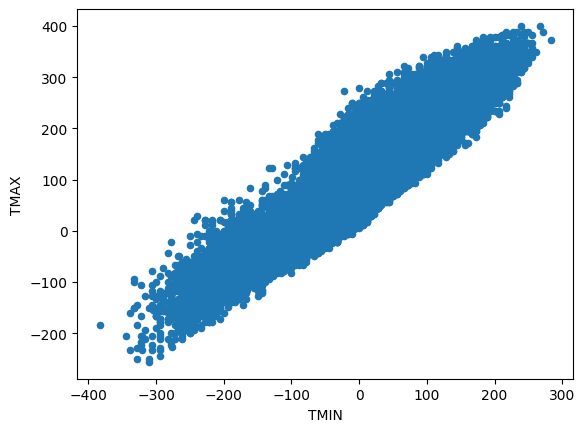

In [11]:
temps.plot.scatter(x="TMIN", y="TMAX")

In [ ]:
# PyTorch Data:
# 1. Dataset
# 2. DataLoader: use DataSet, but provide shuffling and batching

In [19]:
import torch
torch.tensor(temps[["TMAX"]].values, dtype=torch.float32)

tensor([[194.],
        [211.],
        [233.],
        ...,
        [ 28.],
        [ 22.],
        [  0.]])

In [20]:
# all data is in memory at the same time
ds = torch.utils.data.TensorDataset(
    torch.tensor(temps[["TMIN"]].values, dtype=torch.float32),
    torch.tensor(temps[["TMAX"]].values, dtype=torch.float32))

In [23]:
ds[1]

(tensor([33.]), tensor([211.]))

In [25]:
type(ds).__mro__

(torch.utils.data.dataset.TensorDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [38]:
class TempDS(torch.utils.data.dataset.Dataset):
    def __init__(self, path):
        df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])
        df2 = df[df["element"].isin(["TMIN", "TMAX"])]
        temps = df2.pivot(index="date", columns="element", values="value")
        self.X = torch.tensor(temps[["TMIN"]].values, dtype=torch.float32)
        self.Y = torch.tensor(temps[["TMAX"]].values, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

ds = TempDS("https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014837.csv.gz")

/tmp/ipykernel_273679/841781102.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [39]:
ds[1]

(tensor([33.]), tensor([211.]))

In [40]:
ds[:5]

(tensor([[  6.],
         [ 33.],
         [ 89.],
         [106.],
         [133.]]),
 tensor([[194.],
         [211.],
         [233.],
         [272.],
         [211.]]))

In [41]:
ds[:]

(tensor([[  6.],
         [ 33.],
         [ 89.],
         ...,
         [  0.],
         [  0.],
         [-32.]]),
 tensor([[194.],
         [211.],
         [233.],
         ...,
         [ 28.],
         [ 22.],
         [  0.]]))

In [42]:
len(ds)

30428

In [43]:
ds2 = TempDS("https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014839.csv.gz")

/tmp/ipykernel_273679/841781102.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [45]:
len(ds + ds2)

61404

In [58]:
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=10)

In [60]:
for x, y in dl:
    print(x)
    print(y)
    break

tensor([[  0.],
        [-11.],
        [111.],
        [-56.],
        [117.],
        [-56.],
        [ 83.],
        [-61.],
        [ 50.],
        [ 78.]])
tensor([[ 39.],
        [ 28.],
        [261.],
        [ 11.],
        [267.],
        [117.],
        [128.],
        [  0.],
        [189.],
        [283.]])


In [ ]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD([model.weight, model.bias], lr=0.0001)
loss_fn = torch.nn.MSELoss()

for epoch in range(50):
    for batchx, batchy in dl:
        predictedy = model(batchx)
        loss = loss_fn(batchy, predictedy)
        # TODO: change model params based on loss